In [1]:
import numpy as np
from numpy.random import rand
from numpy.linalg import solve
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from ldmm import LDMM
from ldmm import ldmm_iteration

random_state=1

## Initialization

In [2]:
t = np.arange(-np.pi, np.pi, 0.01)
n = t.shape[0]
print(n)

X_true = np.concatenate((np.cos(t).reshape(-1, 1), np.sin(t).reshape(-1, 1)), axis=1)

# Embedding into D-dimensional space
D = 10
X_true = np.concatenate((X_true, np.zeros((n, D-X_true.shape[1]))), axis=1)

magnitude = 0.8
noise = magnitude * (rand(n, D) - 0.5)
X = X_true + noise

629


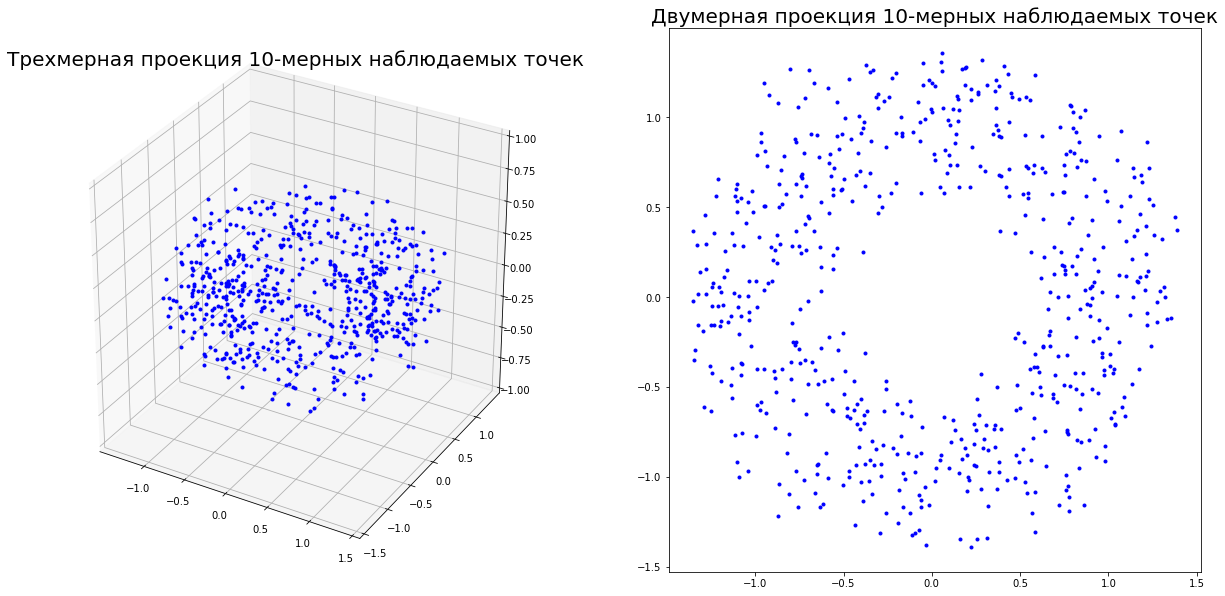

In [3]:
fig = plt.figure(figsize=(21, 10))
ax = fig.add_subplot(121, projection='3d')
ax.plot(X[:, 0], X[:, 1], X[:, 2],'b.',)
ax.set_zlim3d(-1,1)
#ax.set_title('3D projection of ' + str(D) + '-dimensional point cloud', fontsize=16)
ax.set_title('Трехмерная проекция ' + str(D) + '-мерных наблюдаемых точек', fontsize=20)
ax = fig.add_subplot(122)
ax.plot(X[:, 0], X[:, 1],'b.',)
#ax.set_title('2D projection of ' + str(D) + '-dimensional point cloud', fontsize=16)
ax.set_title('Двумерная проекция ' + str(D) + '-мерных наблюдаемых точек', fontsize=20)
#plt.savefig('sample.png')
plt.show()
plt.close()

In [4]:
h = 0.1
X_recovered = LDMM(X, lambd=0.5, mu=0.2 * n * h, h=h, n_iterations=8)
print(np.linalg.norm(X_recovered - X_true))

6.2240633641


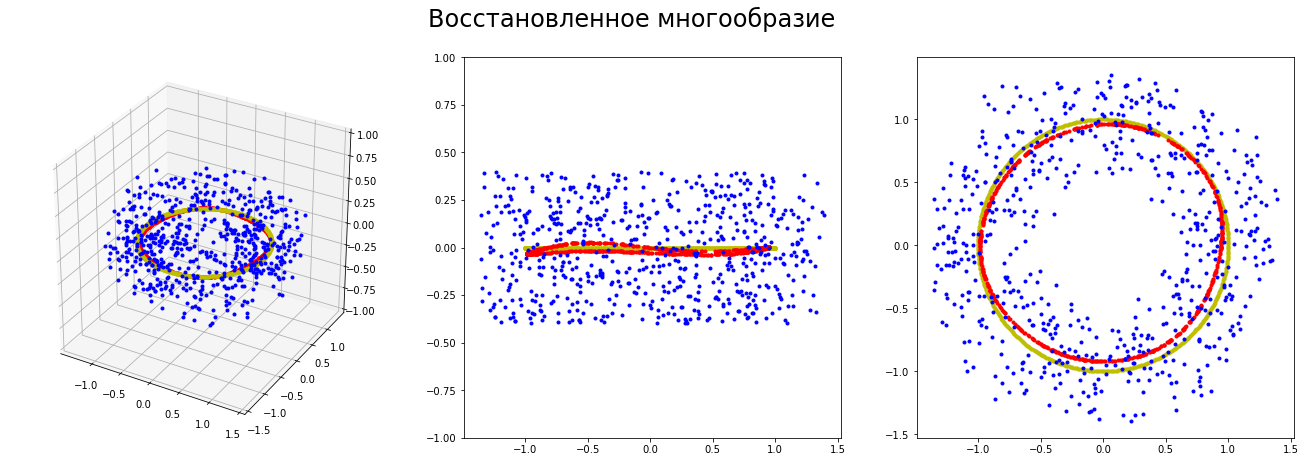

In [5]:
fig = plt.figure(figsize=(23, 7))
ax = fig.add_subplot(131, projection='3d')
ax.plot(X_recovered[:, 0], X_recovered[:, 1], X_recovered[:, 2],'r.',)
ax.plot(X_true[:, 0], X_true[:, 1], X_true[:, 2],'y.',)
ax.plot(X[:, 0], X[:, 1], X[:, 2],'b.',)
ax.set_zlim3d(-1,1)
#ax.set_title('3D projection of the recovered manifold', fontsize=16)
ax = fig.add_subplot(132)
ax.plot(X_true[:, 0], X_true[:, 2],'y.',)
ax.plot(X_recovered[:, 0], X_recovered[:, 2],'r.',)
ax.plot(X[:, 0], X[:, 2],'b.',)
ax.set_ylim(-1,1)
#ax.set_title('2D projection of the recovered manifold', fontsize=16)
ax = fig.add_subplot(133)
ax.plot(X_true[:, 0], X_true[:, 1],'y.',)
ax.plot(X_recovered[:, 0], X_recovered[:, 1],'r.',)
ax.plot(X[:, 0], X[:, 1],'b.',)
#ax.set_title('2D projection of the recovered manifold', fontsize=16)
plt.suptitle('Восстановленное многообразие', fontsize=24)
#plt.savefig('ldmm_result.png')
plt.show()
plt.close()

## LDMM with bootstrap

### Construction of confidence sets via resampling

In [6]:
# Bootstrap procedure for manifold learning
#
# parameters X, lambd, mu, h, n_iterations, eps
# are the same as in the function LDMM
#
# bootstrap_iterations -- number of the bootstrap iterations
#
# RETURNS: Xb -- ((bootstrap_iterations*n_instances) x n_features)-array corresponding
# to the bootstrap_iterations recovered manifolds from reweighted points in the cloud

def bootstrap(X, bootstrap_iterations, lambd, mu, h=0.1, n_iterations=-1, eps=1e-2):
    
    Xb = np.empty((n, D))
    
    # Bootstrap iterations
    for i in range(bootstrap_iterations):
    
        # Generate bootstrap weights
        bootstrap_weights = 0.1 * np.random.randn(n) + 1
        # Run the LDMM procedure with reweighted points
        X_recovered = LDMM(X, lambd, mu, h=h, weights=bootstrap_weights, n_iterations=4)
        Xb = np.append(Xb, X_recovered, axis=0)
        
    return Xb[n:, :]

In [7]:
h = 0.1
Xb = bootstrap(X, bootstrap_iterations=10, lambd=0.5, mu=0.2 * n * h, h=h, n_iterations=4)
print(Xb.shape)

(6290, 10)


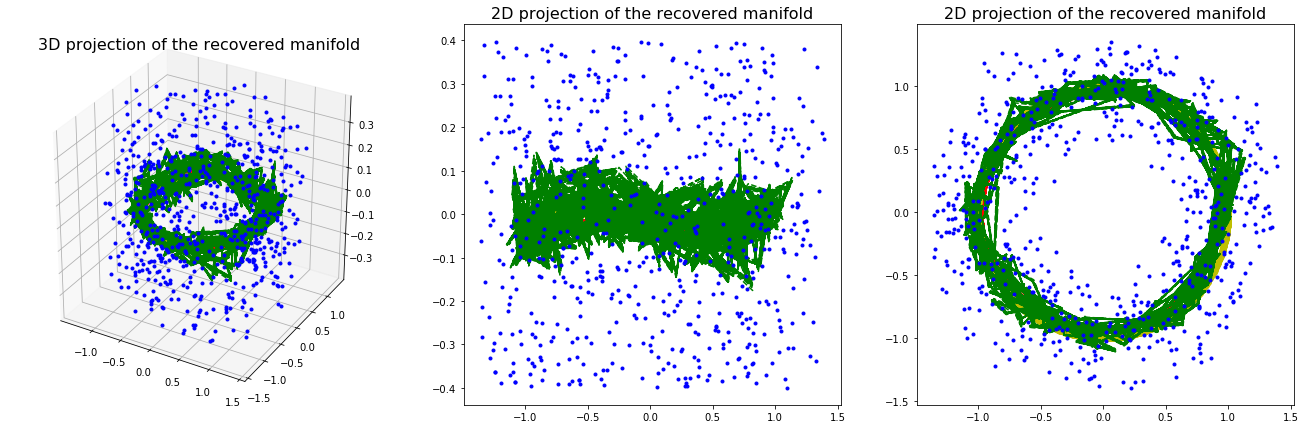

In [8]:
fig = plt.figure(figsize=(23, 7))
#plt.plot(X_true[:, 0], X_true[:, 1], 'r-')
ax = fig.add_subplot(131, projection='3d')
ax.plot(X_recovered[:, 0], X_recovered[:, 1], X_recovered[:, 2],'ro',)
ax.plot(X_true[:, 0], X_true[:, 1], X_true[:, 2],'yo',)
ax.plot(Xb[:, 0], Xb[:, 1], Xb[:, 2],'g--',)
ax.plot(X[:, 0], X[:, 1], X[:, 2],'b.',)
ax.set_title('3D projection of the recovered manifold', fontsize=16)
ax = fig.add_subplot(132)
ax.plot(X_recovered[:, 0], X_recovered[:, 2],'ro',)
ax.plot(X_true[:, 0], X_true[:, 2],'yo',)
ax.plot(Xb[:, 0], Xb[:, 2],'g--',)
ax.plot(X[:, 0], X[:, 2],'b.',)
ax.set_title('2D projection of the recovered manifold', fontsize=16)
ax = fig.add_subplot(133)
ax.plot(X_recovered[:, 0], X_recovered[:, 1],'ro',)
ax.plot(X_true[:, 0], X_true[:, 1],'yo',)
ax.plot(Xb[:, 0], Xb[:, 1],'g--',)
ax.plot(X[:, 0], X[:, 1],'b.',)
ax.set_title('2D projection of the recovered manifold', fontsize=16)
plt.show()
plt.close()

## QQ-plot

In [9]:
# Generate points on the manifold

t = np.arange(-np.pi, np.pi, 0.01)
n = t.shape[0]
print(n)

X_true = np.concatenate((np.cos(t).reshape(-1, 1), np.sin(t).reshape(-1, 1)), axis=1)

# Embedding into D-dimensional space
D = 10
X_true = np.concatenate((X_true, np.zeros((n, D-X_true.shape[1]))), axis=1)

629


In [10]:
n_samples=500

### Real world

In [11]:
magnitude = 0.5
h = 0.1

# Statistics of interest
stat_real = np.empty(1)

for i in range(n_samples):
    
    # Generate noisy observations
    noise = magnitude * (rand(n, D) - 0.5)
    X = X_true + noise
    
    X_recovered = LDMM(X, lambd=0.5, mu=0.2 * n * h, h=h, n_iterations=4)

    # Compute statistics of interest
    stat_real = np.append(stat_real, 1/n * np.linalg.norm(X_recovered - X_true, ord='fro')**2)
    
stat_real = stat_real[1:]
print(stat_real.shape)

(500,)


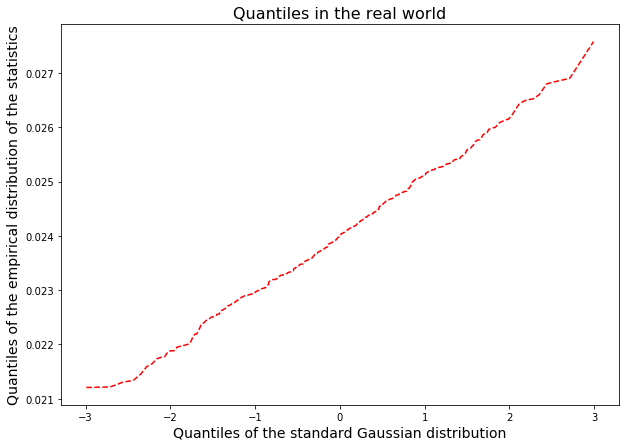

Determination coefficient: 0.998748236482


In [12]:
quantiles_real, params = stats.probplot(stat_real, fit='False', plot=None)

plt.figure(figsize=(10, 7))
plt.plot(quantiles_real[0], quantiles_real[1], 'r--')
plt.title('Quantiles in the real world', fontsize=16)
plt.xlabel('Quantiles of the standard Gaussian distribution', fontsize=14)
plt.ylabel('Quantiles of the empirical distribution of the statistics', fontsize=14)
plt.show()
print('Determination coefficient:', params[2])

### Bootstrap world

In [13]:
magnitude = 0.5
h = 0.1

# Generate noisy observations
noise = magnitude * (rand(n, D) - 0.5)
X = X_true + noise

# Recovered manifold
X_recovered = LDMM(X, lambd=0.5, mu=0.2 * n * h, h=h, n_iterations=4)

# Statistics of interest
stat_bootstrap = np.empty(1)
    
Xb = bootstrap(X, bootstrap_iterations=n_samples, lambd=0.5, mu=0.2 * n * h, h=h, n_iterations=4)

for i in range(n_samples):
    stat_bootstrap = np.append(stat_bootstrap, 1/n * np.linalg.norm(Xb[i*n:(i+1)*n, :] - X_recovered, ord='fro')**2)

stat_bootstrap = stat_bootstrap[1:]
print(stat_bootstrap.shape)

(500,)


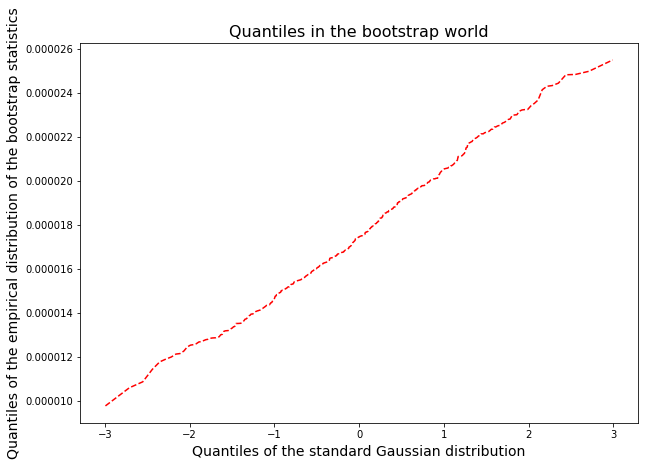

Determination coefficient: 0.997642716847


In [14]:
quantiles_bootstrap, params = stats.probplot(stat_bootstrap, fit='False', plot=None)

plt.figure(figsize=(10, 7))
plt.plot(quantiles_bootstrap[0], quantiles_bootstrap[1], 'r--')
plt.title('Quantiles in the bootstrap world', fontsize=16)
plt.xlabel('Quantiles of the standard Gaussian distribution', fontsize=14)
plt.ylabel('Quantiles of the empirical distribution of the bootstrap statistics', fontsize=14)
plt.show()
print('Determination coefficient:', params[2])

## QQ-plot

In [15]:
# This value maust be equal to zero!
print(np.linalg.norm(quantiles_bootstrap[0] - quantiles_real[0]))

0.0


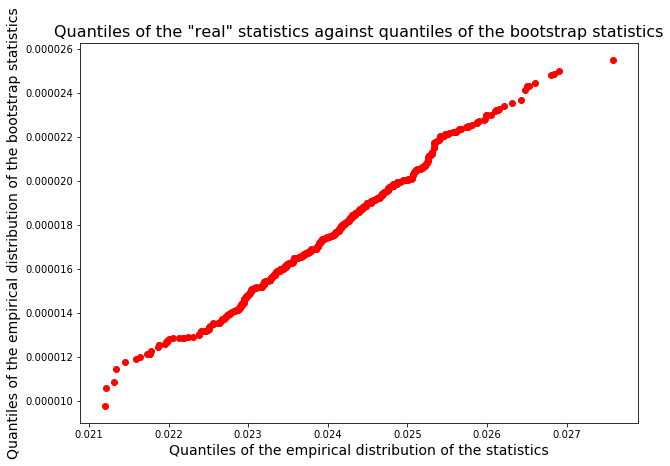

In [16]:
plt.figure(figsize=(10, 7))
#plt.plot(quantiles_real[1], quantiles_bootstrap[1], 'r--')
plt.plot(quantiles_real[1], quantiles_bootstrap[1], 'ro')
plt.title('Quantiles of the "real" statistics against quantiles of the bootstrap statistics', fontsize=16)
plt.xlabel('Quantiles of the empirical distribution of the statistics', fontsize=14)
plt.ylabel('Quantiles of the empirical distribution of the bootstrap statistics', fontsize=14)
plt.show()



In [17]:
lr = LinearRegression()
lr.fit(quantiles_bootstrap[1].reshape(-1,1), quantiles_real[1].reshape(-1))
r2 = lr.score(quantiles_bootstrap[1].reshape(-1,1), quantiles_real[1].reshape(-1))
print('Determination coefficient:', r2)

Determination coefficient: 0.993383410928
